In [1]:
%load_ext autoreload
%autoreload 2

## Find more info here -- 
https://github.com/matterport/Mask_RCNN/blob/master/samples/balloon/balloon.py

In [2]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import matplotlib.pyplot as plt

In [3]:
from data_utils import Dataset

In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

In [5]:
class Config(object):
    """Base configuration class. For custom configurations, create a
    sub-class that inherits from this one and override properties
    that need to be changed.
    """
    # Name the configurations. For example, 'COCO', 'Experiment 3', ...etc.
    # Useful if your code needs to do things differently depending on which
    # experiment is running.
    NAME = None  # Override in sub-classes

    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1

    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 2

    # Number of training steps per epoch
    # This doesn't need to match the size of the training set. Tensorboard
    # updates are saved at the end of each epoch, so setting this to a
    # smaller number means getting more frequent TensorBoard updates.
    # Validation stats are also calculated at each epoch end and they
    # might take a while, so don't set this too small to avoid spending
    # a lot of time on validation stats.
    STEPS_PER_EPOCH = 1000

    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    VALIDATION_STEPS = 50

    # Backbone network architecture
    # Supported values are: resnet50, resnet101.
    # You can also provide a callable that should have the signature
    # of model.resnet_graph. If you do so, you need to supply a callable
    # to COMPUTE_BACKBONE_SHAPE as well
    BACKBONE = "resnet101"

    # Only useful if you supply a callable to BACKBONE. Should compute
    # the shape of each layer of the FPN Pyramid.
    # See model.compute_backbone_shapes
    COMPUTE_BACKBONE_SHAPE = None

    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]

    # Size of the fully-connected layers in the classification graph
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024

    # Size of the top-down layers used to build the feature pyramid
    TOP_DOWN_PYRAMID_SIZE = 256

    # Number of classification classes (including background)
    NUM_CLASSES = 1  # Override in sub-classes

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]

    # Anchor stride
    # If 1 then anchors are created for each cell in the backbone feature map.
    # If 2, then anchors are created for every other cell, and so on.
    RPN_ANCHOR_STRIDE = 1

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    
    # ROIs kept after tf.nn.top_k and before non-maximum suppression
    PRE_NMS_LIMIT = 6000

    # ROIs kept after non-maximum suppression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Input image resizing
    # Generally, use the "square" resizing mode for training and predicting
    # and it should work well in most cases. In this mode, images are scaled
    # up such that the small side is = IMAGE_MIN_DIM, but ensuring that the
    # scaling doesn't make the long side > IMAGE_MAX_DIM. Then the image is
    # padded with zeros to make it a square so multiple images can be put
    # in one batch.
    # Available resizing modes:
    # none:   No resizing or padding. Return the image unchanged.
    # square: Resize and pad with zeros to get a square image
    #         of size [max_dim, max_dim].
    # pad64:  Pads width and height with zeros to make them multiples of 64.
    #         If IMAGE_MIN_DIM or IMAGE_MIN_SCALE are not None, then it scales
    #         up before padding. IMAGE_MAX_DIM is ignored in this mode.
    #         The multiple of 64 is needed to ensure smooth scaling of feature
    #         maps up and down the 6 levels of the FPN pyramid (2**6=64).
    # crop:   Picks random crops from the image. First, scales the image based
    #         on IMAGE_MIN_DIM and IMAGE_MIN_SCALE, then picks a random crop of
    #         size IMAGE_MIN_DIM x IMAGE_MIN_DIM. Can be used in training only.
    #         IMAGE_MAX_DIM is not used in this mode.
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Minimum scaling ratio. Checked after MIN_IMAGE_DIM and can force further
    # up scaling. For example, if set to 2 then images are scaled up to double
    # the width and height, or more, even if MIN_IMAGE_DIM doesn't require it.
    # However, in 'square' mode, it can be overruled by IMAGE_MAX_DIM.
    IMAGE_MIN_SCALE = 0
    # Number of color channels per image. RGB = 3, grayscale = 1, RGB-D = 4
    # Changing this requires other changes in the code. See the WIKI for more
    # details: https://github.com/matterport/Mask_RCNN/wiki
    IMAGE_CHANNEL_COUNT = 3

    # Image mean (RGB)
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 200

    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33

    # Pooled ROIs
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14

    # Shape of output mask
    # To change this you also need to change the neural network mask branch
    MASK_SHAPE = [28, 28]

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 100

    # Bounding box refinement standard deviation for RPN and final detections.
    RPN_BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])
    BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 100

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

    # Learning rate and momentum
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimizer
    # implementation.
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9

    # Weight decay regularization
    WEIGHT_DECAY = 0.0001

    # Loss weights for more precise optimization.
    # Can be used for R-CNN training setup.
    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.,
        "rpn_bbox_loss": 1.,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.,
        "mrcnn_mask_loss": 1.
    }

    # Use RPN ROIs or externally generated ROIs for training
    # Keep this True for most situations. Set to False if you want to train
    # the head branches on ROI generated by code rather than the ROIs from
    # the RPN. For example, to debug the classifier head without having to
    # train the RPN.
    USE_RPN_ROIS = True

    # Train or freeze batch normalization layers
    #     None: Train BN layers. This is the normal mode
    #     False: Freeze BN layers. Good when using a small batch size
    #     True: (don't use). Set layer in training mode even when predicting
    TRAIN_BN = False  # Defaulting to False since batch size is often small

    # Gradient norm clipping
    GRADIENT_CLIP_NORM = 5.0

    def __init__(self):
        """Set values of computed attributes."""
        # Effective batch size
        self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT

        # Input image size
        if self.IMAGE_RESIZE_MODE == "crop":
            self.IMAGE_SHAPE = np.array([self.IMAGE_MIN_DIM, self.IMAGE_MIN_DIM,
                self.IMAGE_CHANNEL_COUNT])
        else:
            self.IMAGE_SHAPE = np.array([self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM,
                self.IMAGE_CHANNEL_COUNT])

        # Image meta data length
        # See compose_image_meta() for details
        self.IMAGE_META_SIZE = 1 + 3 + 3 + 4 + 1 + self.NUM_CLASSES

    def display(self):
        """Display Configuration values."""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))
        print("\n")

In [6]:
class BalloonConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "balloon"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


class BalloonDataset(Dataset):

    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("balloon", 1, "balloon")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "balloon",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [7]:
def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()
    

def display_top_masks(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")

In [8]:
config = BalloonConfig()
BALLOON_DIR = "./data/balloon/"
BALLOON_DIR                           

'./data/balloon/'

In [9]:
dataset = BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 61
Class Count: 2
  0. BG                                                
  1. balloon                                           


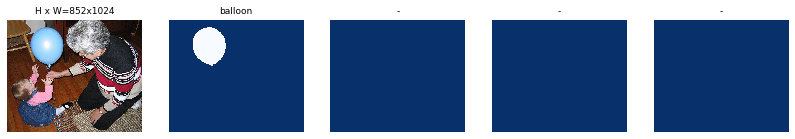

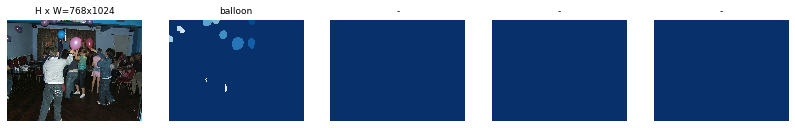

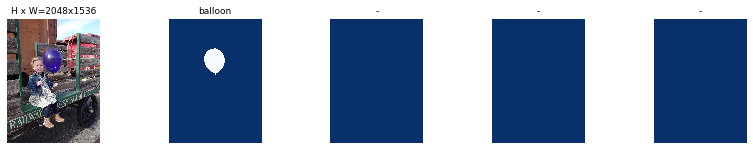

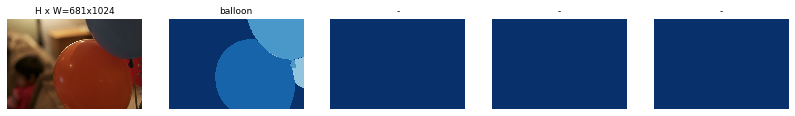

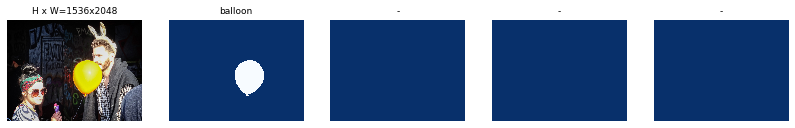

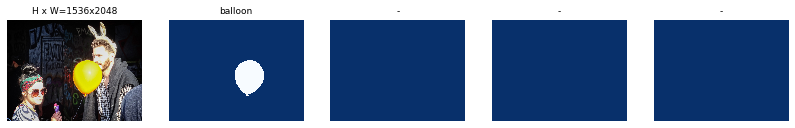

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 6)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    display_top_masks(image, mask, class_ids, dataset.class_names)

In [11]:
## clone this repo -- 
## git clone https://github.com/woctezuma/VIA2COCO

In [12]:
sys.path.append('./VIA2COCO/')

In [13]:
import convert as via2coco

In [17]:
first_class_index = 0
data_path = './data/'
for keyword in ['train', 'val']:
    input_dir = data_path + 'balloon/' + keyword + '/'
    input_json = input_dir + 'via_region_data.json'
    categories = ['balloon']
    super_categories = ['N/A']
    output_json = input_dir + 'custom_' + keyword + '.json'

    print('Converting {} from VIA format to COCO format'.format(input_json))

    coco_dict = via2coco.convert(
      imgdir=input_dir,
      annpath=input_json,
      categories=categories,
      super_categories=super_categories,
      output_file_name=output_json,
      first_class_index=first_class_index,
    )

Converting ./data/balloon/train/via_region_data.json from VIA format to COCO format
Saving to ./data/balloon/train/custom_train.json
Converting ./data/balloon/val/via_region_data.json from VIA format to COCO format
Saving to ./data/balloon/val/custom_val.json
